In [1]:
import math
import pickle
import itertools
import os
import glob
import random

import bpe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%config InlineBackend.figure_format = 'retina'
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm.autonotebook import tqdm, trange
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from dalle_pytorch import VQGanVAE1024, DALLE, OpenAIDiscreteVAE

<ipython-input-1-faef67a61fb1>:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load Data

In [22]:
# https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999
class ImgCaptionDataSet(Dataset):
    def __init__(self, main_dir, img_transform, caption_map,
                 caption_transform, use_cache=False):
        self.main_dir = main_dir
        self.img_transform = img_transform
        self.all_imgs = os.listdir(main_dir)
        self.caption_map = caption_map
        self.caption_transform = caption_transform
        self.img_cache = [None] * len(self.all_imgs)
        self.use_cache = use_cache

    def shuffle(self):
        zipped_items = list(zip(self.all_imgs, self.img_cache))
        random.shuffle(zipped_items)
        self.all_imgs, self.img_cache = zip(*zipped_items)
        self.all_imgs = list(self.all_imgs)
        self.img_cache = list(self.img_cache)
        
    def get_batch_iter(self, batch_size):
        for i in range(0, len(self.all_imgs), batch_size):
            yield self[i:i+batch_size]
        
    def __len__(self):
        return len(self.all_imgs)

    def _load_img(self, idx):
        if self.use_cache and self.img_cache[idx] is not None:
            return self.img_cache[idx]
        
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        try:
            image = Image.open(img_loc).convert("RGB")
        except UnidentifiedImageError as e:
            print('UnidentifiedImageError! Skipping image.')
            return None
        tensor_img = self.img_transform(image).cuda()
        
        if self.use_cache:
            self.img_cache[idx] = tensor_img
        
        img_idx = os.path.basename(img_loc).replace(".png", "")
        caption = self.caption_map[img_idx]
        caption_tokens, caption_mask = self.caption_transform(caption)
        caption_tokens = caption_tokens.cuda()
        caption_mask = caption_mask.cuda()
        
        return tensor_img, caption_tokens, caption_mask
    
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self._load_img(idx)
        elif isinstance(idx, slice):
            start = idx.start or 0
            end = idx.stop or len(self.all_imgs)
            step = idx.step or 1
            
            if start < 0:
                start = len(self.all_imgs) + start
            if end < 0:
                end = len(self.all_imgs) + end
            end = min(end, len(self.all_imgs))
            
            imgs = []
            captions = []
            masks = []
            for i in range(start, end, step):
                loaded_img_data = self._load_img(i)
                
                if loaded_img_data is None:
                    continue
                    
                iter_img, iter_caption_tokens, iter_mask = loaded_img_data
                
                iter_img = iter_img.unsqueeze(0)
                iter_caption_tokens = iter_caption_tokens.unsqueeze(0)
                iter_mask = iter_mask.unsqueeze(0)
                
                imgs.append(iter_img)
                captions.append(iter_caption_tokens)
                masks.append(iter_mask)
                
            imgs_tensor = torch.cat(imgs, dim=0)
            captions_tensor = torch.cat(captions, dim=0)
            mask_tensor = torch.cat(masks, dim=0)
            
            return imgs_tensor, captions_tensor, mask_tensor

def display_imgs(img):
    img = img.cpu().detach()
        
    if len(img.shape) == 3:
        plt.imshow(img.permute(1, 2, 0))
    elif len(img.shape) == 4:
        img = img.permute(2, 0, 3, 1)
        img = img.reshape(img.shape[0], img.shape[1] * img.shape[2], img.shape[3])
        plt.figure(figsize=(30,8))
        plt.imshow(img)
        plt.axis("off")
    else:
        raise ValueError('img parameter did not have the right number of dimensions!')

In [23]:
data_dir = '../data/google_captions/'
img_dir = os.path.join(data_dir, 'imgs/')
captions_fp = os.path.join(data_dir, 'gcc_train_data.tsv')
tokenizer_path = 'data/tokenizer.pkl'

In [5]:
vocab_size = 4096
max_token_count = 30

In [6]:
captions_df = pd.read_csv(captions_fp, delimiter='\t', header=None, names=['caption'], usecols=[0])
caption_indices = [str(x) for x in captions_df.index]
captions = captions_df['caption'].values
captions_map = dict(zip(caption_indices, captions))

In [7]:
captions_corpus = list(captions_map.values())

if os.path.exists(tokenizer_path) and os.path.isfile(tokenizer_path):
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
else:
    tokenizer = bpe.Encoder(vocab_size)
    tokenizer.fit(captions_corpus)
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)

def encode_caption(sentence, tokenizer, max_len=30):
    tokens = next(tokenizer.transform([sentence]))
    padded_tokens = torch.zeros((max_len), dtype=torch.int32)
    padded_tokens[:min(len(tokens), max_len)] = torch.tensor(tokens)[:max_len]
    mask = (padded_tokens != 0) #.int()
    return padded_tokens, mask

In [24]:
caption_encode_func = lambda sentence: encode_caption(sentence, tokenizer, max_token_count)
dataset = ImgCaptionDataSet(
    main_dir = img_dir,
    img_transform = transforms.ToTensor(),
    caption_map = captions_map,
    caption_transform = caption_encode_func)

In [9]:
data_iter = dataset.get_batch_iter(10)
sample_imgs, sample_captions, sample_masks = next(data_iter)

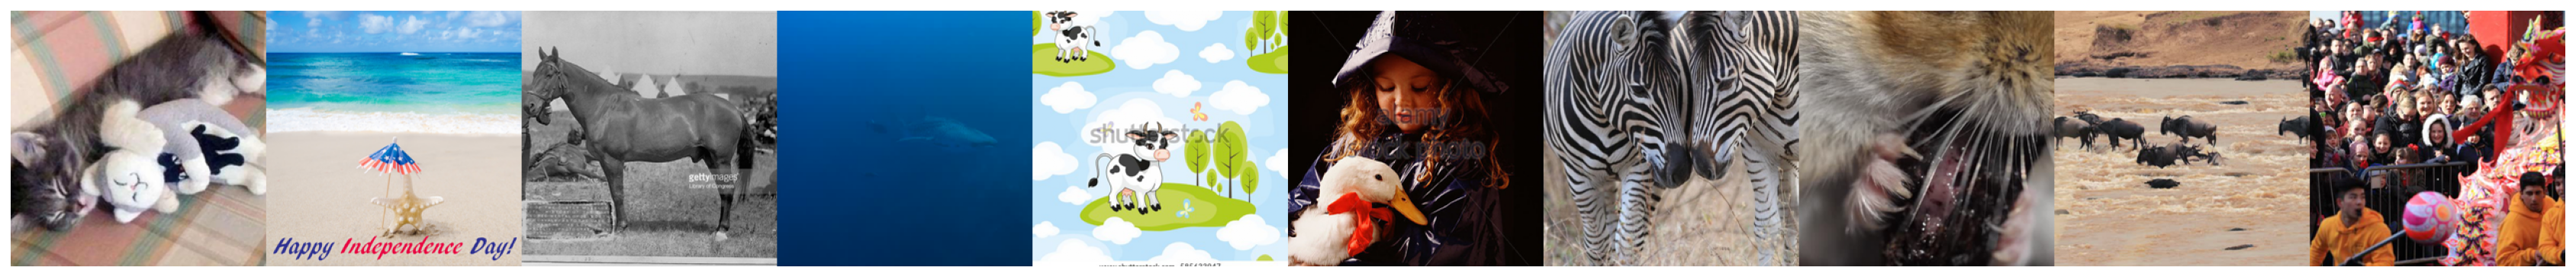

In [10]:
display_imgs(sample_imgs)

In [11]:
vae = VQGanVAE1024().cuda() # OpenAIDiscreteVAE()

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [12]:
with torch.no_grad():
    all_img_codes = vae.get_codebook_indices(sample_imgs)
    all_imgs_decoded = vae.decode(all_img_codes)
all_img_codes.shape

torch.Size([10, 256])

## Random Reconstruction

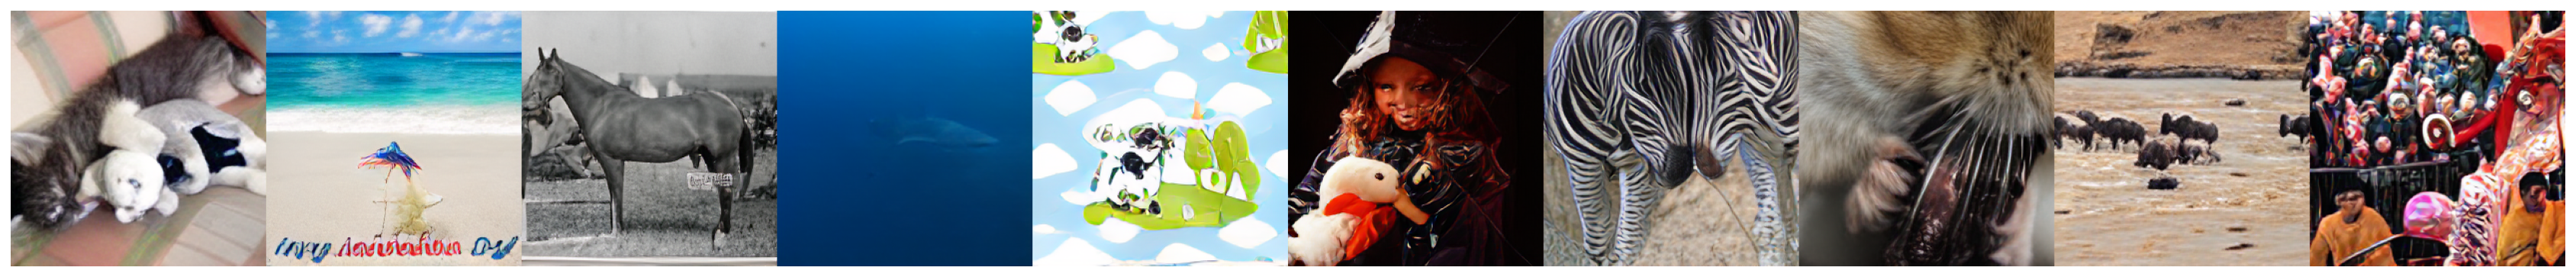

In [13]:
display_imgs(all_imgs_decoded)

# Training DALL-E

In [14]:
# import gc
# del dalle
# gc.collect()
# torch.cuda.empty_cache()

In [15]:
dalle = DALLE(
    dim = 1024,
    vae = vae,                      # automatically infer (1) image sequence length and (2) number of image tokens
    num_text_tokens = vocab_size,   # vocab size for text
    text_seq_len = max_token_count, # text sequence length
    depth = 12,                     # should aim to be 64
    heads = 16,                     # attention heads
    dim_head = 64,                  # attention head dimension
    attn_dropout = 0.1,             # attention dropout
    ff_dropout = 0.1                # feedforward dropout
).cuda()

optimizer = torch.optim.Adam(dalle.parameters(), lr=0.001, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)

In [16]:
def train_dalle_batch(dalle, vae, train_data, _, __, ___):
    imgs, tokens, masks = train_data
    img_codes = vae.get_codebook_indices(imgs)
    loss = dalle(tokens, img_codes, mask=masks, return_loss=True)
    return loss

In [25]:
def fit(dalle, vae, optimizer, criterion, scheduler, dataset, epochs, batch_size,
        model_file, trainer, log_freq=50, save_freq=500, ):
    epoch_loss_train = []

    n_train_samples = len(dataset)
    n_batches = n_train_samples // batch_size

    vae.eval()
    t = trange(epochs)
    for epoch in t:
        dataset.shuffle()
        data_iter = dataset.get_batch_iter(batch_size)
        losses = []
        for batch_idx, train_data in tqdm(enumerate(data_iter), total=n_batches):
            try:
                dalle.train()
                optimizer.zero_grad()
                loss = trainer(dalle, vae, train_data, None, None, None)
                loss.backward()
                losses.append(loss.item())
                optimizer.step()

                # Ocasionally print losses
                if (batch_idx + 1) % log_freq == 0:
                    avg_loss = np.mean(losses[-batch_size:])
                    print('Epoch #{} batch #{} | Avg loss: {:.4f}'.format(
                        epoch+1, batch_idx+1, avg_loss))

                # Ocasionally save the model
                if (batch_idx + 1) % save_freq == 0:
                    print('Saving a model checkpoint')
                    torch.save(dalle.state_dict(), model_file)
            except Exception as e:
                print(e)
                print('Ran into error during training batch, skipping batch.')
                continue

        epoch_loss_train.append(np.mean(losses))
        scheduler.step()

        t.set_description(f"train: {epoch_loss_train[-1]:.3f}")

    torch.save(model.state_dict(), model_file)
    dalle.eval()
    return model, epoch_loss_train

In [ ]:
if os.path.exists(dalle_model_file):
    dalle.load_state_dict(torch.load(dalle_model_file))

In [59]:
dalle_model_file = "data/animal_dalle.model"
n_epochs = 10
batch_size = 8

dalle, loss_history = fit(dalle, vae, optimizer, None, scheduler, dataset, n_epochs,
                          batch_size, dalle_model_file, train_dalle_batch)

plt.plot(loss_history)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/22380 [00:00<?, ?it/s]

Epoch #1 batch #50 | Avg loss: 4.9277
Epoch #1 batch #100 | Avg loss: 4.8211
Epoch #1 batch #150 | Avg loss: 4.7521
Epoch #1 batch #200 | Avg loss: 4.7977
UnidentifiedImageError! Skipping img
UnidentifiedImageError! Skipping img
Epoch #1 batch #250 | Avg loss: 4.5924
Epoch #1 batch #300 | Avg loss: 4.8424
Epoch #1 batch #350 | Avg loss: 4.7364
Epoch #1 batch #400 | Avg loss: 4.8780
Epoch #1 batch #450 | Avg loss: 4.7191
Epoch #1 batch #500 | Avg loss: 4.7349
Saving a model checkpoint
UnidentifiedImageError! Skipping img
Epoch #1 batch #550 | Avg loss: 4.7179
Epoch #1 batch #600 | Avg loss: 4.6723
Epoch #1 batch #650 | Avg loss: 4.8193
Epoch #1 batch #700 | Avg loss: 4.8143
Epoch #1 batch #750 | Avg loss: 4.6159
Epoch #1 batch #800 | Avg loss: 4.7893
Epoch #1 batch #850 | Avg loss: 4.9678
Epoch #1 batch #900 | Avg loss: 4.7676
Epoch #1 batch #950 | Avg loss: 4.6957
UnidentifiedImageError! Skipping img
Epoch #1 batch #1000 | Avg loss: 4.9422
Saving a model checkpoint
Epoch #1 batch #1050

KeyboardInterrupt: 

## Train set examples

In [60]:
data_iter = dataset.get_batch_iter(10)

In [75]:
ssample_imgs, ssample_captions, ssample_masks = next(data_iter)

In [76]:
with torch.no_grad():
    generated_imgs = dalle.generate_images(ssample_captions, mask=ssample_masks, temperature=0.00001)

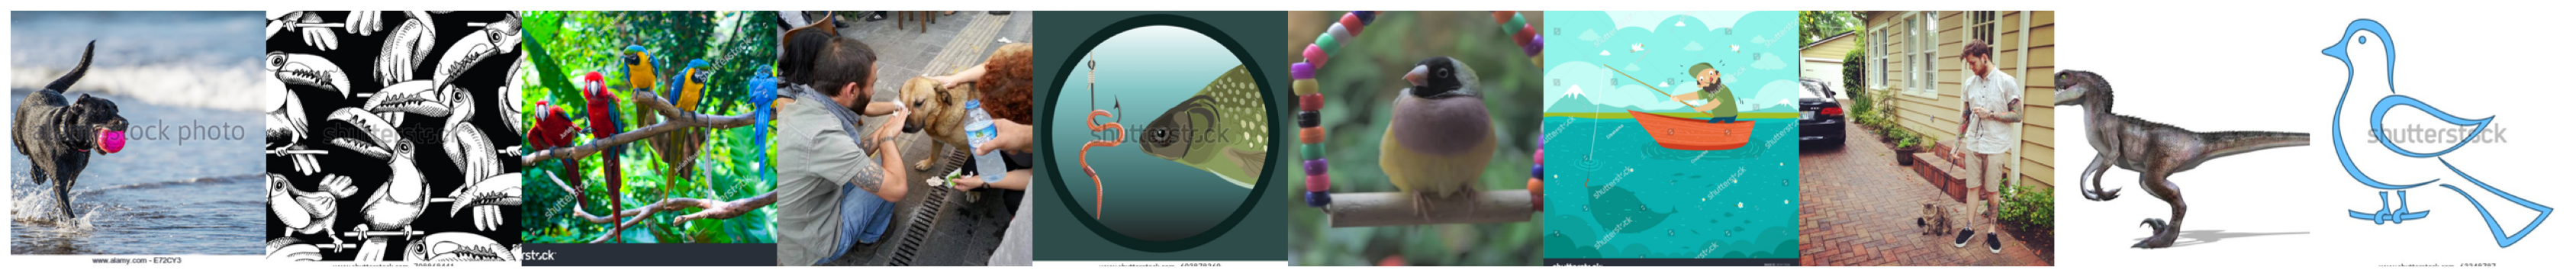

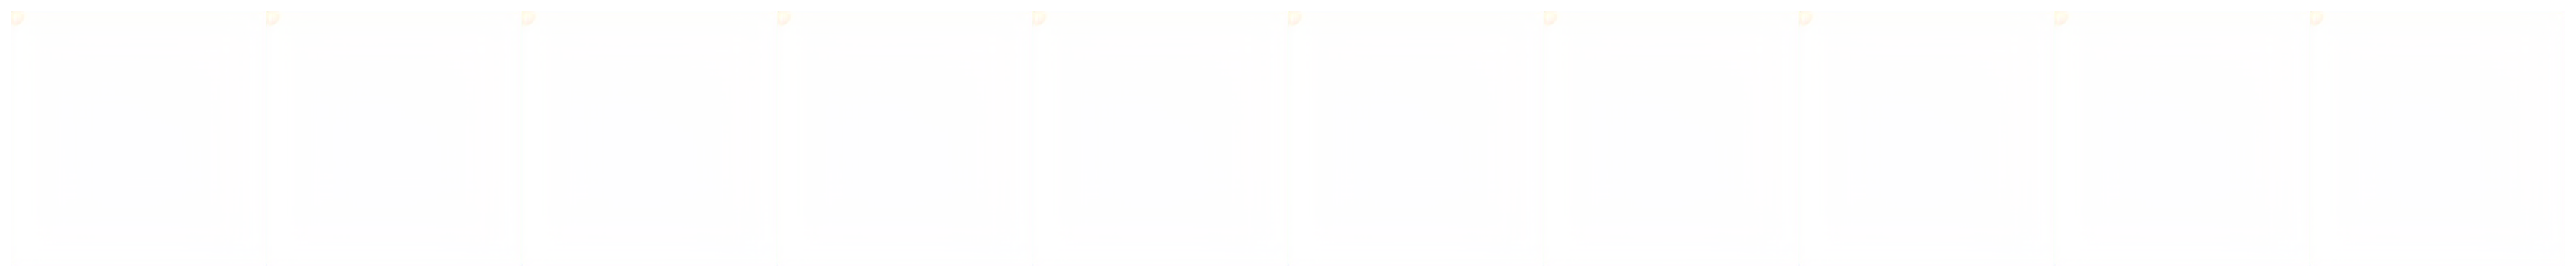

In [77]:
display_imgs(ssample_imgs)
display_imgs(generated_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

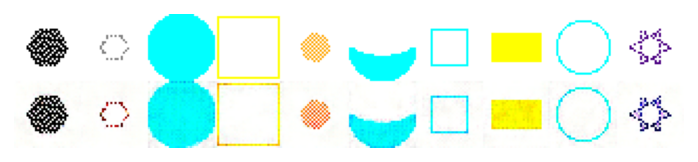

In [58]:
idx = np.random.choice(train_idx, 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = generated_images[idx, ...].transpose(0, 2, 3, 1).reshape(320, 32, 3).transpose(1, 0, 2)
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")

## Test set examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

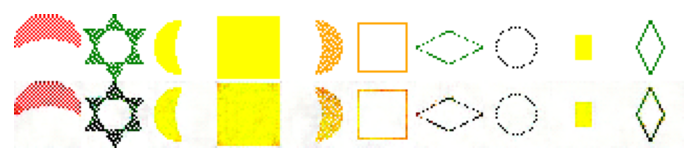

In [59]:
test_idx = np.ones(len(captions), bool)
test_idx[train_idx] = False
test_idx = np.flatnonzero(test_idx)
idx = np.random.choice(test_idx, 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = generated_images[idx, ...].transpose(0, 2, 3, 1).reshape(320, 32, 3).transpose(1, 0, 2)
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")

In [60]:
def generate_image_code(dalle, text, mask):
    vae, text_seq_len, image_seq_len, num_text_tokens = dalle.vae, dalle.text_seq_len, dalle.image_seq_len, dalle.num_text_tokens
    total_len = text_seq_len + image_seq_len
    out = text

    for cur_len in range(text.shape[1], total_len):
        is_image = cur_len >= text_seq_len

        text, image = out[:, :text_seq_len], out[:, text_seq_len:]

        logits = dalle(text, image, mask = mask)[:, -1, :]
        chosen = torch.argmax(logits, dim=1, keepdim=True)
        chosen -= (num_text_tokens if is_image else 0) # offset sampled token if it is an image token, since logit space is composed of text and then image tokens
        out = torch.cat((out, chosen), dim=-1)

        if out.shape[1] <= text_seq_len:
            mask = F.pad(mask, (0, 1), value=True)

    img_seq = out[:, -image_seq_len:]
    return img_seq

In [61]:
generated_image_codes = []
with torch.no_grad():
    for i in trange(0, len(captions), 128):
        generated = generate_image_code(dalle, captions_array[i:i + 128, ...], mask=captions_mask[i:i + 128, ...])
        generated_image_codes.append(generated)
        
generated_image_codes = torch.cat(generated_image_codes, axis=0)

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
    generated_images = vae.decode(generated_image_codes)

## Test Set Accuracy

Train accuracy: 0.98, test accuracy: 0.47


Text(0.5, 0, 'position of image token')

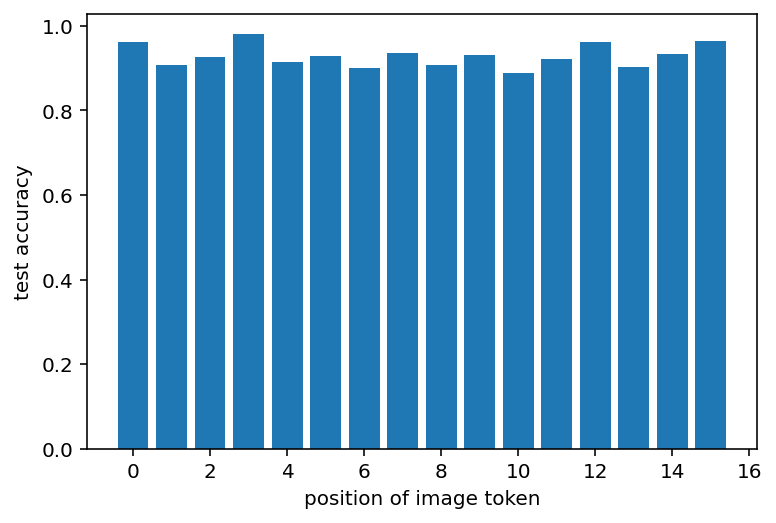

In [62]:
wrong_image_codes = (all_image_codes != generated_image_codes).sum(axis=1) != 0
print(f"Train accuracy: {1 - wrong_image_codes[train_idx].sum().item() / len(train_idx):.2f}, "
      f"test accuracy: {1 - wrong_image_codes[test_idx].sum().item() / len(test_idx):.2f}")

accuracy_by_position = 1 - ((all_image_codes != generated_image_codes).sum(axis=0) / len(test_idx)).cpu().numpy()
plt.bar(range(len(accuracy_by_position)), accuracy_by_position)
plt.ylabel("test accuracy")
plt.xlabel("position of image token")

## Wrong Prediction Examples

In [66]:
wrong_idx = np.flatnonzero((wrong_image_codes).cpu().numpy())
idx = np.random.choice(wrong_idx, 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = generated_images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'